In [1]:
import torch
import torch.nn as nn
from torch import optim
from torch.autograd import Variable

import os
import numpy as np
import scipy as sp
import matplotlib.pyplot as plt
import librosa
import random
import copy

from tqdm import tqdm_notebook as tqdm
from datetime import datetime

In [2]:
n_mels = 80
fs = 44100
frame_length_ms=50
frame_shift_ms=25
nsc = int(fs * frame_length_ms / 1000)
nov = nsc - int(fs * frame_shift_ms / 1000)
nhop = int(fs * frame_shift_ms / 1000)
eps = 1e-8
db_ref = 160

meta_path = "D:/korean-single-speaker-speech-dataset/transcript.v.1.2.txt"
data_folder = "D:/korean-single-speaker-speech-dataset/kss"

with open(meta_path, encoding='utf-8') as f:
    metadata = np.array([line.strip().split('|') for line in f])
#     hours = sum((int(x[2]) for x in metadata)) * frame_shift_ms / (3600 * 1000)
#     log('Loaded metadata for %d examples (%.2f hours)' % (len(metadata), hours))

# metadata = metadata[:32, :2]

max_sequence_len = max(list(map(len, metadata[:, 1])))

error_jamos = [5868, 5998, 6046, 6155, 6202, 
               6654, 6890, 7486, 7502, 7744, 
               7765, 8267, 9069, 9927, 10437, 
               10515, 10533, 10606, 10610, 12777]

print(metadata.shape)
metadata = np.delete(metadata, error_jamos, axis = 0)
print(metadata.shape)

dataset_size = len(metadata)

(12853, 5)
(12833, 5)


In [3]:
character_length = list()
file_length = list()
division_length = list()
unicode_jamo_list = list()

for i in range(len(metadata)):
    character_length.append(len(metadata[i, 3]))
    file_length.append(float(metadata[i, 4]))
    division_length.append(float(metadata[i, 4]) * 1000 / len(metadata[i, 3]))

In [4]:
wave_name_list = []

for data in metadata:
    wave_name_list.append(data[0])

In [5]:
unicode_jamo_list = list()
for unicode in range(0x1100, 0x1113):
    unicode_jamo_list.append(chr(unicode))
    
for unicode in range(0x1161, 0x1176):
    unicode_jamo_list.append(chr(unicode))
    
for unicode in range(0x11A8, 0x11C3):
    unicode_jamo_list.append(chr(unicode))
    
unicode_jamo_list += [' ', '!', ',', '.', '?', '<sos>', '<eos>']
    
unicode_jamo_list.sort()

print(unicode_jamo_list)
print(len(unicode_jamo_list))

[' ', '!', ',', '.', '<eos>', '<sos>', '?', 'ᄀ', 'ᄁ', 'ᄂ', 'ᄃ', 'ᄄ', 'ᄅ', 'ᄆ', 'ᄇ', 'ᄈ', 'ᄉ', 'ᄊ', 'ᄋ', 'ᄌ', 'ᄍ', 'ᄎ', 'ᄏ', 'ᄐ', 'ᄑ', 'ᄒ', 'ᅡ', 'ᅢ', 'ᅣ', 'ᅤ', 'ᅥ', 'ᅦ', 'ᅧ', 'ᅨ', 'ᅩ', 'ᅪ', 'ᅫ', 'ᅬ', 'ᅭ', 'ᅮ', 'ᅯ', 'ᅰ', 'ᅱ', 'ᅲ', 'ᅳ', 'ᅴ', 'ᅵ', 'ᆨ', 'ᆩ', 'ᆪ', 'ᆫ', 'ᆬ', 'ᆭ', 'ᆮ', 'ᆯ', 'ᆰ', 'ᆱ', 'ᆲ', 'ᆳ', 'ᆴ', 'ᆵ', 'ᆶ', 'ᆷ', 'ᆸ', 'ᆹ', 'ᆺ', 'ᆻ', 'ᆼ', 'ᆽ', 'ᆾ', 'ᆿ', 'ᇀ', 'ᇁ', 'ᇂ']
74


In [6]:
class Tokenizer():
    def __init__(self, vocabs):
        self.vocabs = vocabs
        
    def word2num(self, sentence):
        tokens = list()
        for char in sentence:
            tokens.append(self.vocabs.index(char))    
        return tokens
        
    def word2vec(self, sentence):
        vectors = np.zeros((len(sentence), len(self.vocabs)))
        for i, char in enumerate(sentence):
            vectors[i, self.vocabs.index(char)] = 1   
        return vectors
    
    def num2word(self, num):
        output = list()
        for i in num:
            output.append(self.vocabs[i])
        return output
    
    def num2vec(self, numbers):
        vectors = np.zeros((len(numbers), len(self.vocabs)))
        for i, num in enumerate(numbers):
            vectors[i, num] = 1   
        return vectors

In [7]:
tokenizer = Tokenizer(unicode_jamo_list)
jamo_tokens = tokenizer.word2num(unicode_jamo_list)

In [8]:
mel_path_list = list()

for i, wav_name in enumerate(tqdm(wave_name_list)):
    
    npy_name = wav_name.replace('.wav', '.npy')
    wav_path = os.path.join(data_folder, wav_name)  
    mel_path = os.path.join(data_folder + '/mel', npy_name)
    mel_path_list.append(mel_path)
    
    if not os.path.isfile(mel_path):
#         print("{}".format(mel_path))
        y, sr = librosa.core.load(wav_path)
        f, t, Zxx = sp.signal.stft(y, fs=sr, nperseg=nsc, noverlap=nov)
        Sxx = np.abs(Zxx)
        Sxx = np.maximum(Sxx, eps)

        # plt.figure(figsize=(20,20))
        # plt.imshow(20*np.log10(Sxx), origin='lower')
        # plt.colorbar()
        # plt.show()

        mel_filters = librosa.filters.mel(sr=fs, n_fft=nsc, n_mels=n_mels)
        mel_specgram = np.matmul(mel_filters, Sxx)

    #   log_specgram = 20*np.log10(Sxx)
    #   norm_log_specgram = (log_specgram + db_ref) / db_ref

        log_mel_specgram = 20 * np.log10(np.maximum(mel_specgram, eps))
        norm_log_mel_specgram = (log_mel_specgram + db_ref) / db_ref

    #   np.save(specgram_path, norm_log_specgram)
        np.save(mel_path, norm_log_mel_specgram)
    #   np.save(specgram_path, Sxx)

    #     print(norm_log_mel_specgram.shape[1])

    #     if i % 1000 == 0:
    #         plt.figure(figsize=(8, 4))
    #         plt.imshow(20 * np.log10(Sxx), origin='lower', aspect='auto')
    #         plt.colorbar()
    #         plt.show()

    #         plt.figure(figsize=(8, 4))
    #         plt.imshow(norm_log_mel_specgram, origin='lower', aspect='auto')
    #         plt.colorbar()
    #         plt.show()    

In [9]:
class ResidualGRU(nn.Module):
    def __init__(self, D_in, bidirectional=True):
        super(ResidualGRU, self).__init__()
        self.gru = nn.GRU(D_in, int(D_in/2), bidirectional=bidirectional, batch_first=True)
        self.relu = nn.ReLU()
        
    def forward(self, input_tensor):
        
#         print("Residual Input: {}".format(input_tensor.shape))
        gru_output, _ = self.gru(input_tensor)
        activated = self.relu(gru_output)  
#         print("Residual Output: {}".format(activated.shape))
        output_tensor = torch.add(activated, input_tensor)
        
        return output_tensor

In [222]:
class Encoder(nn.Module):
    def __init__(self, D_in, H, D_out):
        super(Encoder, self).__init__()
        self.H = H
        
        self.fc = torch.nn.Linear(D_in, H)
        self.relu = torch.nn.ReLU()
        self.dropout = nn.Dropout(p=0.2)
        
        self.gru = nn.GRU(H, D_out, bidirectional=True, batch_first=True)

    def forward(self, input_tensor):
            
        output_tensor = self.fc(input_tensor)
        output_tensor = self.relu(output_tensor)
        output_tensor = self.dropout(output_tensor)
        
        output_tensor, _ = self.gru(output_tensor)
        
        return output_tensor
    
class Decoder(nn.Module):
    def __init__(self, H, D_out):
        super(Decoder, self).__init__()
        self.H = H
        
        self.fc_embed = nn.Linear(256, 512)
        self.relu_embed = torch.nn.ReLU()
        self.dropout_embed = nn.Dropout(p=0.2)
        
        self.gru = nn.GRU(H, H, batch_first=True)
        self.attention = ForcedAttentionModule(D_out * 2)
        
        self.fc = nn.Linear(512 * 2, 74)
        self.softmax = nn.Softmax(dim=2)

    def forward(self, input_tensor, hidden_tensor, query, pos):

        output_tensor = self.fc_embed(input_tensor)
        output_tensor = self.relu_embed(output_tensor)
        output_tensor = self.dropout_embed(output_tensor)
        
        output_tensor, hidden_tensor = self.gru(output_tensor, hidden_tensor)
        
        context_vector, alpha = self.attention(query, output_tensor, pos)
        output_tensor = torch.cat([output_tensor, context_vector], dim=2)

        output_tensor = self.fc(output_tensor)
        prediction_tensor = self.softmax(output_tensor)

        return prediction_tensor, hidden_tensor, context_vector, alpha

class AdditiveAttentionModule(torch.nn.Module):
    def __init__(self, H):
        super(AdditiveAttentionModule, self).__init__()
        self.fc_alpha = nn.Linear(H, 1)
        self.W = nn.Linear(H, H)
        self.V = nn.Linear(H, H)
        self.sigmoid = nn.Sigmoid()
        self.softmax = nn.Softmax(dim=1)
        
    def forward(self, query, key):
        output_tensor = torch.tanh(torch.add(self.W(query), self.V(key)))
        e = self.fc_alpha(output_tensor)
        e_sig = self.sigmoid(e)
        alpha = self.softmax(e_sig).transpose(1, 2)
        
        context_vector = torch.bmm(alpha, query)
        
        return context_vector, alpha
    
            
        alpha_forced = torch.zeros(alpha.shape)
    
class MultiplicativeAttentionModule(torch.nn.Module):
    def __init__(self, H):
        super(MultiplicativeAttentionModule, self).__init__()
        self.Wa = nn.Linear(H, H)
        self.softmax = nn.Softmax(dim=1)
        
    def forward(self, query, key):
        input_tensor = self.Wa(key)
        output_tensor = torch.bmm(query, input_tensor.transpose(1, 2))
        alpha = self.softmax(output_tensor).transpose(1, 2)
        context_vector = torch.bmm(alpha, query)
        
        return context_vector, alpha
    
class ForcedAttentionModule(torch.nn.Module):
    def __init__(self, H):
        super(ForcedAttentionModule, self).__init__()
        self.Wa = nn.Linear(H, H)
        self.softmax = nn.Softmax(dim=1)
#         self.force_variable = torch.rand(1, requires_grad=True)
        self.force_variable = Variable(torch.tensor(1.0), requires_grad=True)
        self.sigmoid = nn.Sigmoid()
        
    def forward(self, query, key, pos):
        input_tensor = self.Wa(key)
        output_tensor = torch.bmm(query, input_tensor.transpose(1, 2))
        alpha = self.softmax(output_tensor).transpose(1, 2)
        
        alpha_forced = torch.zeros(alpha.shape).to(device)
        
        if (pos < 5):
            alpha_forced[:, 0, pos:pos + 5] = torch.tensor([5.0, 4.0, 3.0, 2.0 ,1.0]) / 15
            
        elif (pos > alpha.shape[2] - 5):
            alpha_forced[:, 0, pos - 5:pos] = torch.tensor([1.0, 2.0, 3.0, 4.0, 5.0]) / 15
            
        else:
            alpha_forced[:, 0, pos - 4 : pos + 5] = torch.tensor([1.0, 2.0, 3.0, 4.0, 5.0, 4.0, 3.0, 2.0 ,1.0]) / 25
            
        force_rate = self.sigmoid(self.force_variable).to(device)
        pass_rate = Variable(1 - force_rate).to(device)
        
        alpha = torch.add(pass_rate * alpha, force_rate * alpha_forced)
        
        context_vector = torch.bmm(alpha, query)
        
        return context_vector, alpha

class Mel2SeqNet():
    def __init__(self, D_in, H, D_out):
        super(Mel2SeqNet, self).__init__()
        
        device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
        
        self.H = H
        
        self.encoder = Encoder(D_in, H, D_out).to(device)
        self.embedding_layer = nn.Embedding(len(jamo_tokens), 256).to(device)
        self.decoder = Decoder(H, D_out).to(device)

        self.encoder_optimizer = optim.Adam(self.encoder.parameters(), lr=0.0001)
        self.decoder_optimizer = optim.Adam(self.decoder.parameters(), lr=0.0001)
        self.embedding_optimizer = optim.Adam(self.embedding_layer.parameters(), lr=0.0001)

        self.criterion = nn.CrossEntropyLoss(reduction='none').to(device)
        
        for param in self.encoder.parameters():
            param.data.uniform_(-0.1, 0.1)
        for param in self.embedding_layer.parameters():
            param.data.uniform_(-0.1, 0.1)
        for param in self.decoder.parameters():
            param.data.uniform_(-0.1, 0.1)

    def train(self, input_tensor, ground_truth, loss_mask):
        
        batch_size = input_tensor.shape[0]

        self.encoder_optimizer.zero_grad()
        self.decoder_optimizer.zero_grad()
        self.embedding_optimizer.zero_grad()

        encoded_tensor = self.encoder(input_tensor)
        decoder_hidden = encoded_tensor[:, -1, :].view(1, batch_size, self.H).contiguous()

        pred_tensor_list = list()
        att_weight_list = list()
        
        loss = 0
        
        decoder_input = self.embedding_layer(torch.tensor(tokenizer.word2num(['<sos>'] * batch_size)).to(device)).view([batch_size, 1, -1])

        step = torch.tensor(input_tensor.shape[1] / ground_truth.shape[1])
        
        for i in range(ground_truth.shape[1]):
            
            pos = int(np.floor(step * i))
            
            pred_tensor, decoder_hidden, context_vector, att_weight = self.decoder(decoder_input, decoder_hidden, encoded_tensor, pos)
            pred_tensor_list.append(pred_tensor)
            att_weight_list.append(att_weight)
            
            truth = ground_truth[:, i]
            truth = truth.type(torch.cuda.LongTensor)
            
#             print(pred_tensor.shape)
#             print(pred_tensor.view([batch_size, -1]).shape)
#             plt.figure()
#             plt.imshow(pred_tensor.view([batch_size, -1]).detach().cpu().numpy())
#             plt.colorbar()
#             plt.show()
#             print(truth.shape)
#             print(truth)
#             print(self.criterion(pred_tensor.view([batch_size, -1]), truth))
            
            loss += torch.dot(loss_mask[:, i], self.criterion(pred_tensor.view([batch_size, -1]), truth)) / batch_size
            decoder_input = self.embedding_layer(truth).view([batch_size, 1, -1])

        loss.backward()

        self.encoder_optimizer.step()
        self.decoder_optimizer.step()
        self.embedding_optimizer.step()
        
        prediction = torch.cat(pred_tensor_list, dim=1)
        attention_matrix = torch.cat(att_weight_list, dim=1)
        
        return prediction, attention_matrix, loss.item() / ground_truth.shape[1]
    
    def save(self, check_point_name):
        torch.save({
            'embedding_layer_state_dict': self.embedding_layer.state_dict(),
            'encoder_state_dict': self.encoder.state_dict(),
            'decoder_state_dict': self.decoder.state_dict(),
            'embedding_optimizer_state_dict': self.embedding_optimizer.state_dict(),
            'encoder_optimizer_state_dict': self.encoder_optimizer.state_dict(),
            'decoder_optimizer_state_dict': self.decoder_optimizer.state_dict(),
            }, check_point_name)
    
    def load(self, check_point_name):
        checkpoint = torch.load(check_point_name)
        self.embedding_layer.load_state_dict(checkpoint['embedding_layer_state_dict'])
        self.encoder.load_state_dict(checkpoint['encoder_state_dict'])
        self.decoder.load_state_dict(checkpoint['decoder_state_dict'])
        self.embedding_optimizer.load_state_dict(checkpoint['embedding_optimizer_state_dict'])
        self.encoder_optimizer.load_state_dict(checkpoint['encoder_optimizer_state_dict'])
        self.decoder_optimizer.load_state_dict(checkpoint['decoder_optimizer_state_dict'])
    
        self.embedding_layer.eval()
        self.encoder.eval()
        self.decoder.eval()
        self.embedding_layer.train()
        self.encoder.train()
        self.decoder.train()
    
net = Mel2SeqNet(80, 512, 256)

In [223]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")      
print(device)

cuda:0


In [224]:
x = torch.zeros(4, 5, 6)

In [225]:
class Batched_Preloader():
    def __init__(self, mel_path_list, ground_truth_list, batch_size):
        super(Batched_Preloader).__init__()
        self.mel_path_list = mel_path_list
        self.total_num_input = len(mel_path_list)
        self.tensor_input_list = [None] * self.total_num_input
        self.ground_truth_list = ground_truth_list
        self.sentence_length_list = np.asarray(list(map(len, ground_truth_list)))
        self.shuffle_step = 4
        self.loading_sequence = None
        self.end_flag = True
        self.batch_size = batch_size
    
    def load(self, i):
        norm_log_mel_specgram = np.load(self.mel_path_list[i])
        input_spectrogram = norm_log_mel_specgram.T
        tensor_input = torch.tensor(input_spectrogram).view(1, input_spectrogram.shape[0], input_spectrogram.shape[1])
        self.tensor_input_list[i] = tensor_input
        
    def get(self, i):
        if type(self.tensor_input_list[i]) == type(None):
            self.load(i)
        return self.tensor_input_list[i]  
    
    def initialize_batch(self):
        loading_sequence = np.argsort(self.sentence_length_list)
        bundle = np.stack([self.sentence_length_list[loading_sequence], loading_sequence])
        
        for seq_len in range(self.shuffle_step, np.max(self.sentence_length_list), self.shuffle_step):
            idxs = np.where((bundle[0, :] > seq_len) & (bundle[0, :] <= seq_len + self.shuffle_step))[0]
            idxs_origin = copy.deepcopy(idxs)
            random.shuffle(idxs)
            bundle[:, idxs_origin] = bundle[:, idxs]
            
        loading_sequence = bundle[1, :]
        
        self.loading_sequence = loading_sequence
        self.current_loading_index = 0
        self.end_flag = False
        
        return
    
    def get_batch(self):
        
        tensor_list = list()
        ground_truth_list = list()
        tensor_size_list = list()
        ground_truth_size_list = list()
        
        count = 0
        max_seq_len = 0
        max_sen_len = 0
        
        for i in range(self.batch_size):
            
            if self.current_loading_index >= self.total_num_input:
                self.end_flag = True
                break
            
            tensor = self.get(self.loading_sequence[self.current_loading_index])
            tensor_list.append(tensor)
            tensor_size_list.append(tensor.shape[1])
            
            ground_truth = self.ground_truth_list[self.loading_sequence[self.current_loading_index]]
            ground_truth_list.append(ground_truth)
            ground_truth_size_list.append(len(ground_truth))
            
            
            if (tensor.shape[1] > max_seq_len):
                max_seq_len = tensor.shape[1]
            if (len(ground_truth) > max_sen_len):
                max_sen_len = len(ground_truth)  
            
            self.current_loading_index += 1
            count += 1
            
        batched_tensor = torch.zeros(count, max_seq_len, n_mels)
        batched_ground_truth = torch.zeros(count, max_sen_len)
        batched_loss_mask = torch.zeros(count, max_sen_len)
        
        for order in range(count):
            batched_tensor[order, :tensor_size_list[order], :] = tensor_list[order]
            batched_ground_truth[order, :ground_truth_size_list[order]] = torch.tensor(ground_truth_list[order])
            batched_loss_mask[order, :ground_truth_size_list[order]] = torch.ones(ground_truth_size_list[order])
        
        return batched_tensor, batched_ground_truth, batched_loss_mask


In [226]:
ground_truth_list = [(tokenizer.word2num(list(metadata[i, 3]) + ['<eos>'])) for i in range(len(metadata))]

In [230]:
preloader = Batched_Preloader(mel_path_list, ground_truth_list, 32)

In [231]:
# loss = nn.CrossEntropyLoss(reduction='none')
# softmax = nn.Softmax(dim=1)
# input = torch.randn(16, 74, requires_grad=True)
# input= softmax(input)
# target = torch.empty(16, dtype=torch.long).random_(74)
# print(input)
# print(input.shape)
# print(target.shape)
# print(target)
# output = loss(input, target)
# print(output)

08-28 03:40:31
Calculated 100 Batches
Loss 100: 3.720808506011963
08-28 03:40:47


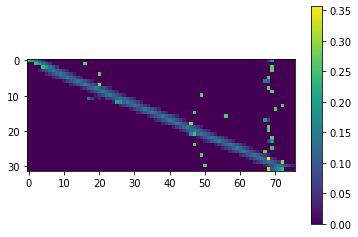

아 아 안인ᅵ 알안아 아.어.<eos>..
내 두 눈으로 분명히 봤어.<eos>  


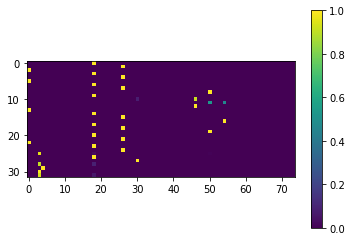

Calculated 200 Batches
Loss 200: 3.7366893768310545
08-28 03:41:10


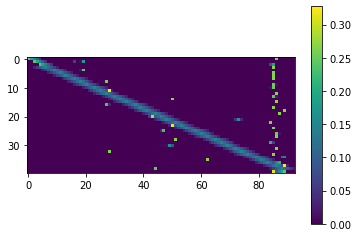

아ᄋ아 ᄋ아 안이 ᅡᆫ 일인ᅡ 있ᅵ ᅡᄋ아.<eos>.ᄋ
공동 생활에는 질서가 요구된다.<eos>  


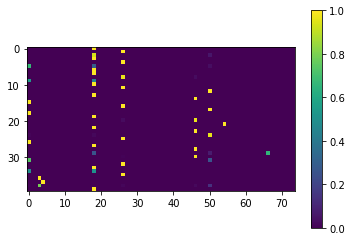

Calculated 300 Batches
Loss 300: 3.7680514653523765
08-28 03:41:38


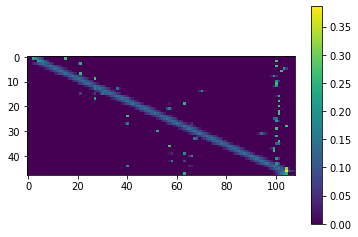

안ᅵᆫ 안ᅡᆫᄋ안ᅡᆫᅡᆫᅵ ᅥ 안아 알이 있얼이아.<eos>.
저는 소형 아파트에서 혼자 살고 있습니다.<eos> 


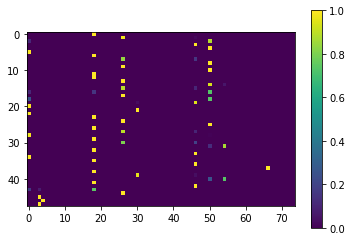

Calculated 400 Batches
Loss 400: 3.6986989107998935
08-28 03:42:14


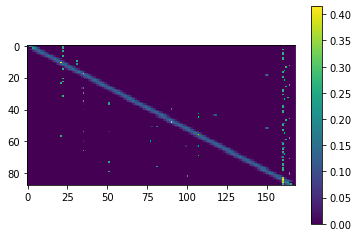

알안안인ᅵ 아 알안ᅡᆫ 안안ᅡ 알ᅡᆫ안일ᅵ 이ᄋ알안ᅵᆫ 알이 안이  아 이ᄋ아.<eos>ᅵᄋᄋᄋᄋ.
긍정적으로 생각하는 것보다 부정적으로 생각하는 것이 훨씬 더 쉽다.<eos>      


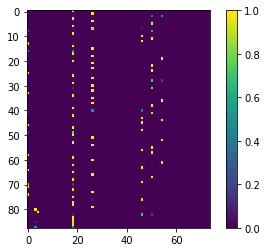

Mean Loss: 3.741598478163357
----------------------------------------------------
08-28 03:42:16
Calculated 100 Batches
Loss 100: 3.6840529441833496
08-28 03:42:32


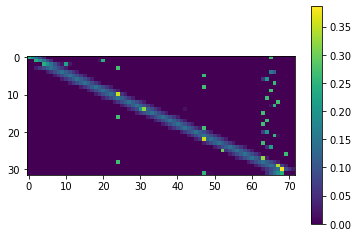

이 ᅡ ᅵᆫ이 ᅡᆫ 이아 이 이 아.아.<eos>.
이태원에는 외국인이 많다.<eos> 


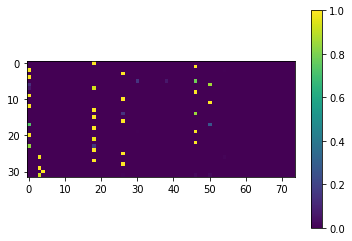

Calculated 200 Batches
Loss 200: 3.8071338653564455
08-28 03:42:56


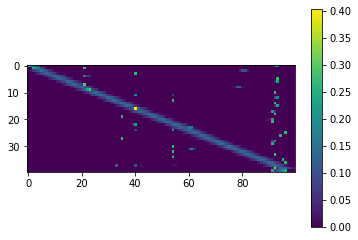

알ᅵᆫ 알ᅡᆫᅥ ᅥ 이ᄋ안일ᅵ 아 얼ᅥ요.<eos>ᆫᄋᄋ
다음 코너에서 왼쪽으로 꺾으세요.<eos>   


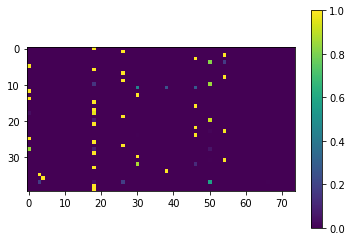

Calculated 300 Batches
Loss 300: 3.7922960917154946
08-28 03:43:27


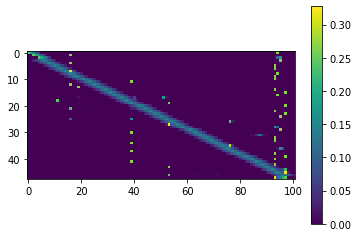

아 안아ᄋᄋ안ᅵᆫ 인ᅵ ᅡᆫ 알ᅵ 아ᄋᄋ알 ᅡᆫ 아요.<eos>ᆫᄋ
내 평생 그런 여자는 다시 못 만날 거야.<eos>  


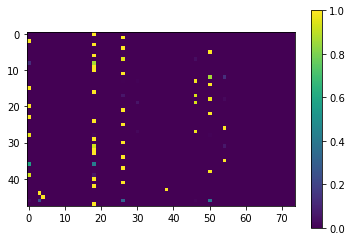

Calculated 400 Batches
Loss 400: 3.7181521329012783
08-28 03:44:03


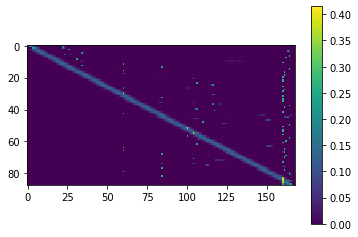

인ᅵ ᅡᆫ 일안ᅵ ᅡᆫᅡᄋ이 알아 알인일 일아 일ᅵᆯ 안이 ᅡ ᅡ 일ᅡ안ᅵ 있얼이 ᅡ.<eos>ᅵᄋᄋᄋᄋᄋ
우리는 이 프로그램이 경제 발전을 촉진시킬 것이라고 기대하고 있습니다.<eos>      


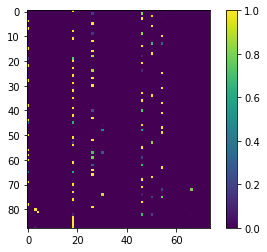

Mean Loss: 3.7407215030312653
----------------------------------------------------
08-28 03:44:04
Calculated 100 Batches
Loss 100: 3.731452703475952
08-28 03:44:20


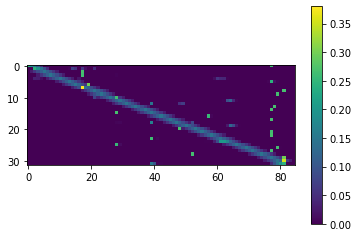

안ᅡᆯ인 알ᅵ 알알ᅵ 알ᅡᄋ아.<eos>.
그들은 나와 동시에 떠났다.<eos> 


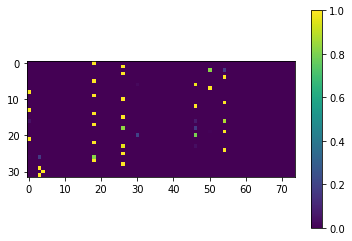

Calculated 200 Batches
Loss 200: 3.754271697998047
08-28 03:44:43


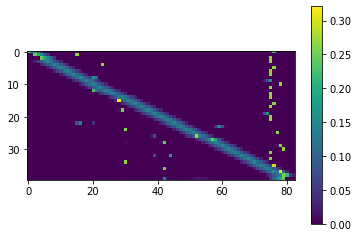

안인ᄋ안 안이 아ᄋᄋ알ᅵ ᅡᆯᅵ ᄋ아요요.<eos>ᅡ
점원 한 명이 곧 도와드릴 거예요.<eos> 


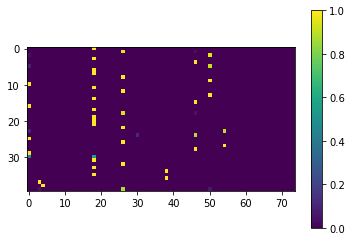

Calculated 300 Batches
Loss 300: 3.8100029627482095
08-28 03:45:11


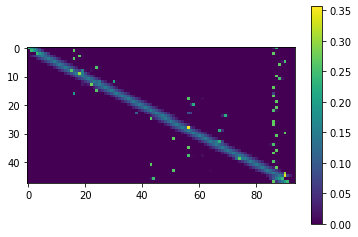

안ᅵᆫ 안ᅥ 안안이 ᅥ 일ᅵᆫ일 알이 얼이아.<eos>.ᄋ
저는 여러 연극에서 조연을 맡았습니다.<eos>  


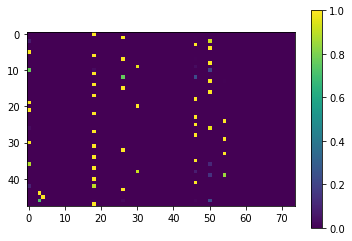

Calculated 400 Batches
Loss 400: 3.7047726024280894
08-28 03:45:47


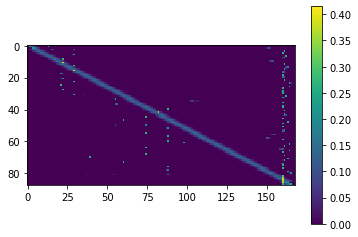

안ᅥᆫ이 알ᅡᆫᅵ 이안안ᅵ ᅡ 안이 일어 이 ᅥ 아이 안ᅵ 알ᅵᆯ일 안 아 ᅡ 있어요.<eos>ᆫᄋᄋᄋᄋᄋᄋ
어떻게 나하고 의논하지도 않고 즉석에서 계약서에 사인을 할 수가 있어요?<eos>       


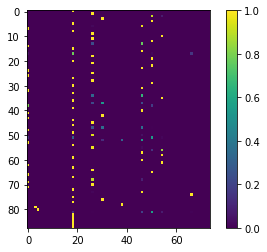

Mean Loss: 3.7396833976660346
----------------------------------------------------
08-28 03:45:49
Calculated 100 Batches
Loss 100: 3.7196221351623535
08-28 03:46:05


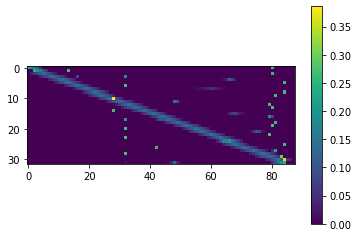

아일 ᅵᆫ 알ᄋ알이 일언 ᅡ요.<eos>.
대출을 좀 받고 싶은데요.<eos> 


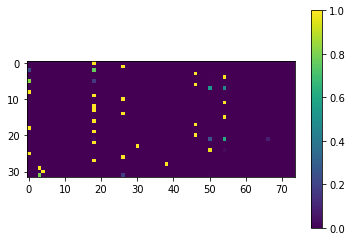

Calculated 200 Batches
Loss 200: 3.7268733978271484
08-28 03:46:28


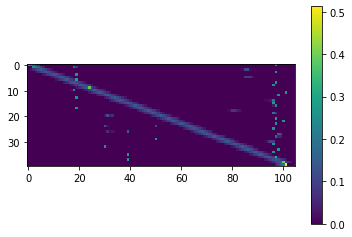

알알ᅡᄋ인 안ᄋ알안 아이 아ᄋ아ᄋ어요.<eos>
그 사람을 몇 달간 보지 못했어요.<eos>


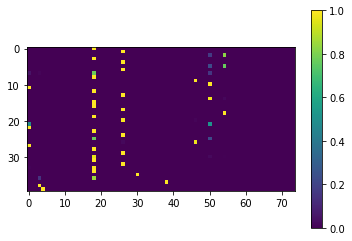

Calculated 300 Batches
Loss 300: 3.8116544087727866
08-28 03:46:56


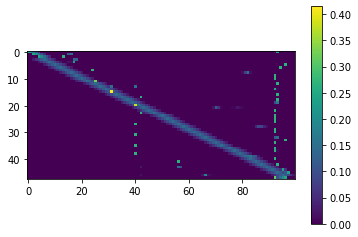

알ᅵᆫ 알ᄋ이 ᅡᆫᅡ ᅵ 알안ᄋ아ᄋᄋ안 아ᄋ알아요.<eos>ᅡᄋ
오늘 밤 세미나에 참석 못 할 거 같아요.<eos>  


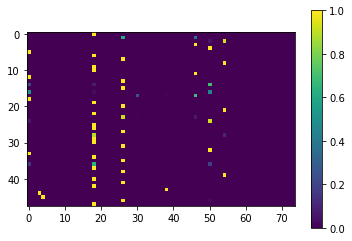

Calculated 400 Batches
Loss 400: 3.710736708207564
08-28 03:47:31


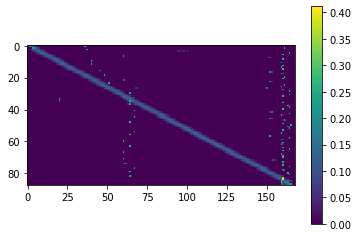

이 ᅵᆯ 알인ᅡᆫᄋ일이 알ᅡ 안 ᅵ 안ᅵ요. 알 안이 ᅭ. 안ᅵᆯ 안이  안ᄋ알안 ᅡ ᅭ.<eos>ᆫᄋᄋᄋᄋᄋ
에이. 그 사람 언제 떠났는지 아세요? 비. 글쎄요, 며칠 전인 것 같은데요.<eos>      


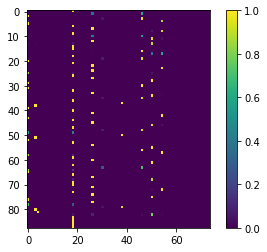

Mean Loss: 3.738660443730391
----------------------------------------------------
08-28 03:47:33
Calculated 100 Batches
Loss 100: 3.7552695274353027
08-28 03:47:49


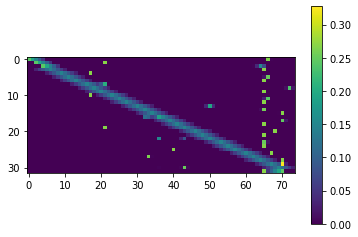

알이 일이 인 ᅵ 안이 아아.<eos>.ᄋ
문이 잠겼는지 확인해라.<eos>  


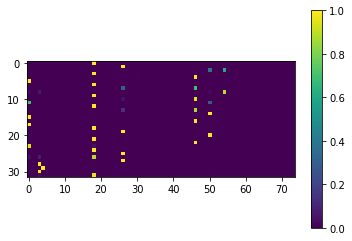

Calculated 200 Batches
Loss 200: 3.76501579284668
08-28 03:48:13


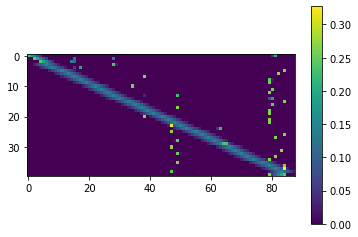

알ᅡᆫ 안이 안 안안일ᅵ 알ᅵ.ᅡ.아.<eos>..
그는 훌륭한 청년으로 자라났다.<eos>  


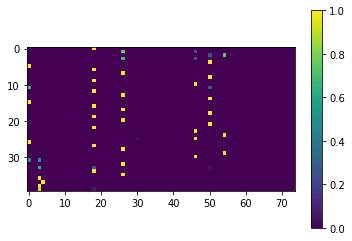

Calculated 300 Batches
Loss 300: 3.7955735524495444
08-28 03:48:41


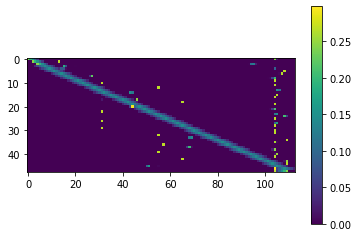

일ᅵᆫ 인아이 ᅥ 알어 ᅡᆫ 안안일 알이ᄋ아.<eos>ᄋᄋᄋ
그는 군대에서 특수한 훈련을 받았다.<eos>   


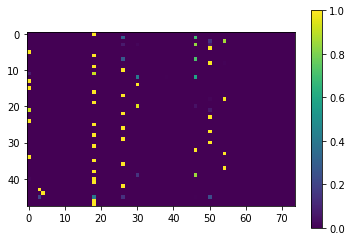

Calculated 400 Batches
Loss 400: 3.7127973383123223
08-28 03:49:17


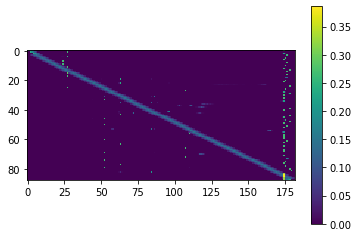

안 ᅡᆫ이 ᅥ ᅡᆫ 아 ᅡᆫᅵ 일 ᅡᆫᅵᆫ 인ᅡᆫᅵᆯᅥᆯ 일ᅥ 안 아 일안ᄋ안이 이 알어 ᅡᆫ이 ᅡ.<eos>ᄋᄋᄋᄋᄋᄋ
한국에서는 대다수 온라인 서비스를 이용할 때 실명 확인이 필요합니다.<eos>      


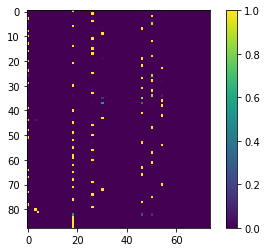

Mean Loss: 3.7371705578135463
----------------------------------------------------
08-28 03:49:18
Calculated 100 Batches
Loss 100: 3.7200865745544434
08-28 03:49:34


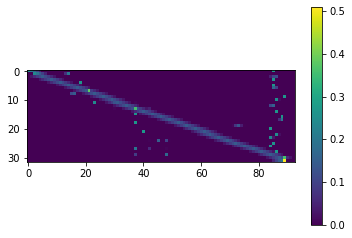

이 안인 안ᅡ ᅡ 알어 안아.ᅡ.<eos>
인간은 누구나 불완전하다.<eos>


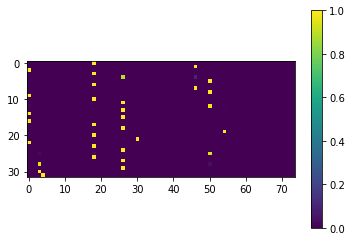

Calculated 200 Batches
Loss 200: 3.7522483825683595
08-28 03:49:59


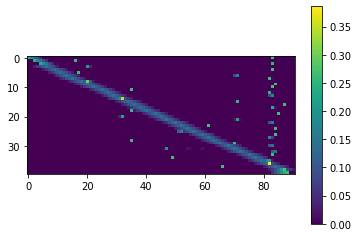

안ᅵ ᅡᆯ이 이ᄋ인 아 ᅵᆯ이 ᅥ 알아 있아.<eos>
아이들이 얕은 개울에서 놀고 있다.<eos>


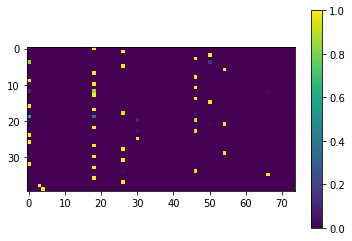

Calculated 300 Batches
Loss 300: 3.7991949717203775
08-28 03:50:29


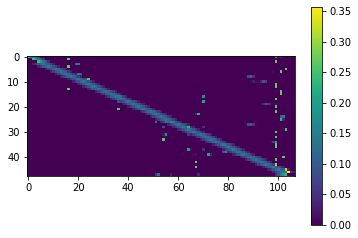

안ᅵᆫ 일ᅵᆯᄋ아 안ᅡᆫ아이 일ᅡ 아안ᄋ알ᅡ 어요.<eos>ᅡ
저는 이십 대 후반까지 키가 계속 자랐어요.<eos> 


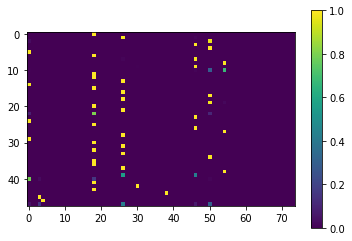

Calculated 400 Batches
Loss 400: 3.7002202814275567
08-28 03:51:06


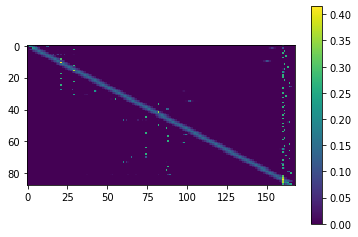

안ᅥᆫ이 알ᅡᆫᅵ 이안안ᅵ ᅡ 안이 일이 이 ᅥ 아이 인ᅵ 알ᅵᆯ일 안 아 ᅡ 있어요.<eos>ᆫᄋᄋᄋᄋᄋᄋ
어떻게 나하고 의논하지도 않고 즉석에서 계약서에 사인을 할 수가 있어요?<eos>       


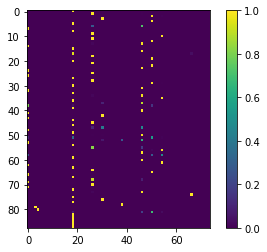

Mean Loss: 3.736292172344793
----------------------------------------------------
08-28 03:51:07
Calculated 100 Batches
Loss 100: 3.708852529525757
08-28 03:51:23


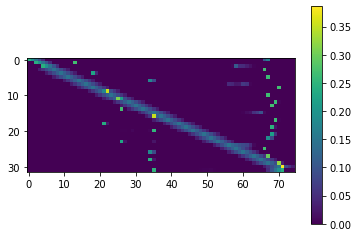

일인ᅵᆯ ᅡᆫᅵ 인ᅵ ᅡᆫᅵ 일어요.<eos>.
집주인하고 얘기하고 싶어요.<eos> 


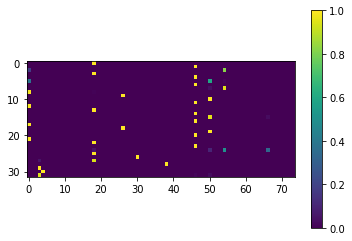

Calculated 200 Batches
Loss 200: 3.7655361175537108
08-28 03:51:48


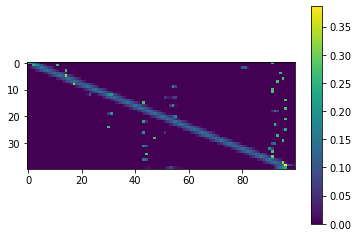

알ᅡ ᅡ 알ᄋ안 ᅵᆯ 알 ᅵ ᅡ ᅵ ᅡ 있어요.<eos>.
파리가 방 안을 날아다니고 있어요.<eos> 


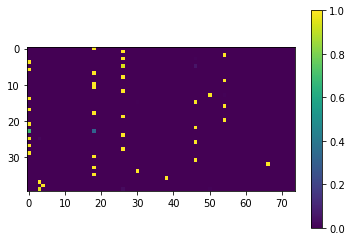

Calculated 300 Batches
Loss 300: 3.7844216028849282
08-28 03:52:18


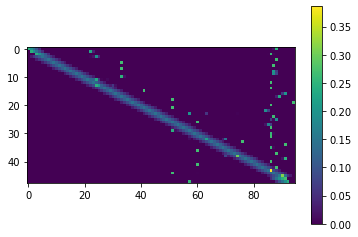

안ᅡ ᅡᆫᅡ 안아이 알알ᅵ 안안일 아어 아ᄋ아.<eos>.
하나부터 열까지 다 다시 설명을 해야 했다.<eos> 


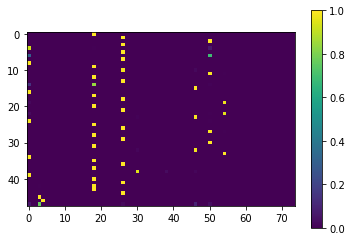

Calculated 400 Batches
Loss 400: 3.706908486106179
08-28 03:52:55


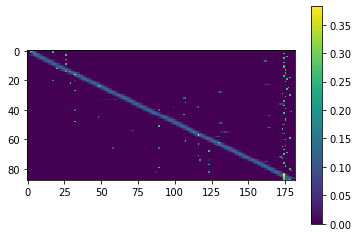

안ᅡ 알아 이 ᅥ ᅡᆫ 아 ᅵ ᅵ 알ᄋ 안안이 ᅡ 안ᅥ 알알알일 알ᅵ 안ᅵ 있얼이 ᅡ.<eos>ᅵᄋᄋᄋᄋᄋ
저희 농장에서는 돼지나 닭, 그 밖에도 여러 동물들을 사육하고 있습니다.<eos>      


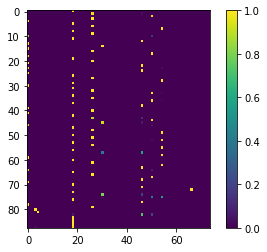

Mean Loss: 3.7358241976535744
----------------------------------------------------
08-28 03:52:57
Calculated 100 Batches
Loss 100: 3.744408369064331
08-28 03:53:13


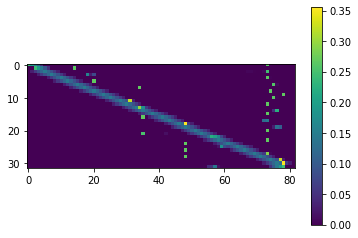

안ᅵᆫᅵ ᅡᆫ 이아 안ᅵ 알일ᅥ요.<eos>.
어머니는 귀가 아주 밝으세요.<eos> 


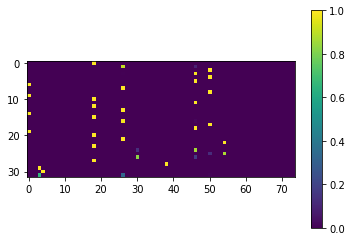

Calculated 200 Batches
Loss 200: 3.763499069213867
08-28 03:53:37


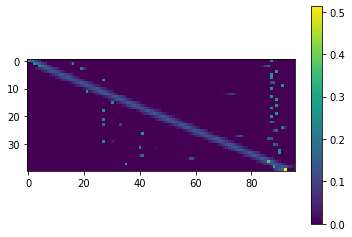

아아 ᄋ안 알ᄋ이 안아 ᅡ 알아아 알어.<eos>
보통 한 달 생활비가 얼마나 들어?<eos>


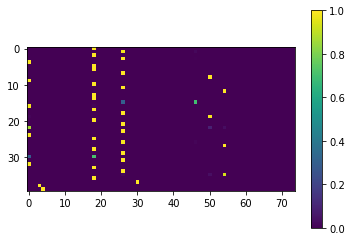

Calculated 300 Batches
Loss 300: 3.7336037953694663
08-28 03:54:08


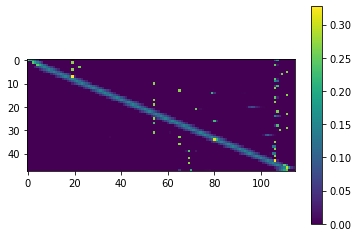

안ᅵᆫ 안아ᄋ일 아알ᅡᆫ 알ᅡᆫ 알ᅵᆯ이 있어요.<eos>.
저는 손톱을 깨무는 나쁜 버릇이 있어요.<eos> 


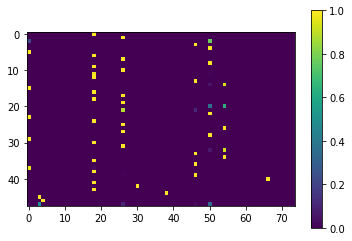

Calculated 400 Batches
Loss 400: 3.7142920060591265
08-28 03:54:45


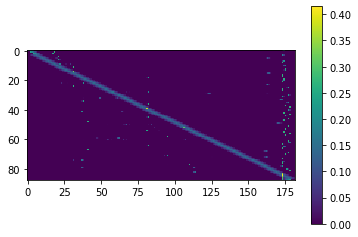

일알ᅡᆫ안ᅵ 일ᄋ안ᄋ일ᅥ ᄋ알 인ᅵ ᅡᆫ ᅡ ᅵᆫ 아 알ᅡ ᅥ ᅡᆫ 알ᅵ  안알 알이 안ᅵᄋ<eos>ᄋᄋᄋᄋᄋᄋ
그 사람하고 십 분 이상 간 얘기한다는 게 나로서는 여간 힘든 일이 아냐.<eos>      


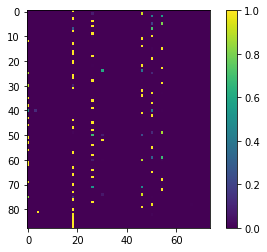

Mean Loss: 3.7351313344990396
----------------------------------------------------
08-28 03:54:46
Calculated 100 Batches
Loss 100: 3.736966133117676
08-28 03:55:02


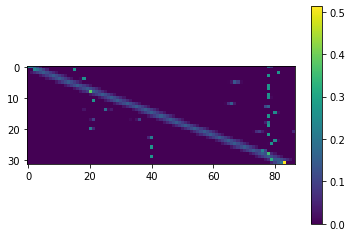

아 일ᄋ안알이 안알이 이ᄋ어.<eos>
생일 선물로 뭐 받고 싶어?<eos>


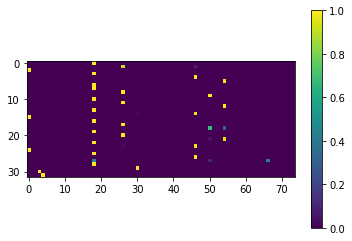

Calculated 200 Batches
Loss 200: 3.783286285400391
08-28 03:55:25


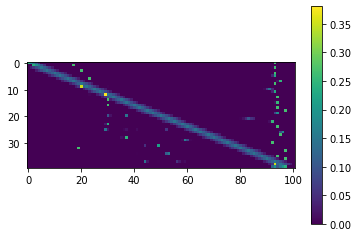

인ᅡᆫ이 아ᄋ안ᅡᆫᅡᆫ 알아 ᅡ 알인 ᅡᄋ<eos>.ᄋᄋ
시험에 통과하면 얼마나 좋을까!<eos>   


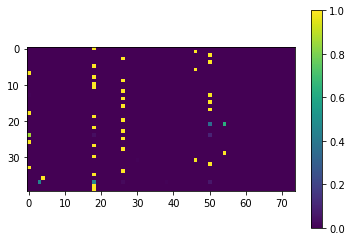

KeyboardInterrupt: 

In [236]:
EPOCH = 15
REPEAT = 1

for epoch in range(EPOCH):
    try:
         net.load('check_point_forced_att')
    except:
        print("Loading Error")
    preloader.initialize_batch()
    counter = 0
    loss_list = list()
    print(datetime.now().strftime('%m-%d %H:%M:%S'))
    
    while preloader.end_flag == False:
        tensor_input, ground_truth, loss_mask = preloader.get_batch()
        
        for i in range(REPEAT):
            pred_tensor, attention_matrix, loss = net.train(tensor_input.to(device), ground_truth.to(device), loss_mask.to(device))
        
        counter += 1
        loss_list.append(loss)
        
        if (counter % 100 == 0):
            print('Calculated {} Batches'.format(counter))
            print('Loss {}: {}'.format(counter, loss))
            print(datetime.now().strftime('%m-%d %H:%M:%S'))

            plt.figure()
            plt.imshow(attention_matrix[0].detach().cpu().numpy())
            plt.colorbar()
            plt.show()
            _, index = pred_tensor[0].max(-1)
            sentence = tokenizer.num2word(index.view(-1))
            print(''.join(sentence))
            true_sentence = tokenizer.num2word(ground_truth[0, :].detach().numpy().astype(int))
            print(''.join(true_sentence))
            
            plt.figure()
            plt.imshow(pred_tensor[0].detach().cpu().numpy())
            plt.colorbar()
            plt.show()

    net.save('check_point_forced_att')
    print("Mean Loss: {}".format(np.mean(np.asarray(loss_list))))
    print("----------------------------------------------------")